* Sergio Muñoz González
* Alicia Peñaranda Navazo

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import urllib.request as urllib
import sys
import warnings
warnings.filterwarnings('ignore')

# Loading data

In [3]:
data= pd.read_csv('prostate.csv')
X = data.values[ :, :-1].astype(np.float)
y = data.values[:,-1]
data.head()


,100_g_at,1000_at,1001_at,1002_f_at,1003_s_at,1004_at,1005_at,1006_at,1007_s_at,1008_f_at,...,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-YEL002c/WBP1_at,AFFX-YEL018w/_at,AFFX-YEL021w/URA3_at,AFFX-YEL024w/RIP1_at,Y
0,6.927460,7.391657,3.812922,3.453385,6.070151,5.527153,5.812353,3.167275,7.354981,9.419909,...,3.770583,2.884436,2.730025,3.126168,2.870161,3.082210,2.747289,3.226588,3.480196,0
1,7.222432,7.329050,3.958028,3.407226,5.921265,5.376464,7.303408,3.108708,7.391872,10.539579,...,3.190759,2.460119,2.696578,2.675271,2.940032,3.126269,3.013745,3.517859,3.428752,1
2,6.776402,7.664007,3.783702,3.152019,5.452293,5.111794,7.207638,3.077360,7.488371,6.833428,...,3.325183,2.603014,2.469759,2.615746,2.510172,2.730814,2.613696,2.823436,3.049716,0
3,6.919134,7.469634,4.004581,3.341170,6.070925,5.296108,8.744059,3.117104,7.203028,10.400557,...,3.625057,2.765521,2.681757,3.310741,3.197177,3.414182,3.193867,3.353537,3.567482,0
4,7.113561,7.322408,4.242724,3.489324,6.141657,5.628390,6.825370,3.794904,7.403024,10.240322,...,3.698067,3.026876,2.691670,3.236030,3.003906,3.081497,2.963307,3.472050,3.598103,1


# KNN performance with all features

In [22]:

# #We set 10 times 10 k fold

n_repeats = 10

rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

knn_all_error= []

for train_index, test_index in rkf.split(X, y):
    
    # PARTITION INTO TRAINING AND TESTING DATASETS
    
    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # STANDARIZATION OF THE DATA (MEAN = 0; STD = 1)

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train= scaler.transform(X_train)
    X_test= scaler.transform(X_test)

    # check the standarization process, not shown in output

    #print(np.var(X_train[:,0]))
    #print(np.var(X_train[:,1]))
    #print(np.var(X_train_scaled[:,0]))
    #print(np.var(X_train_scaled[:,1]))

    # Choosing the best k-neighbor in each cross validation partition with 5 fold cv

    pipeline = Pipeline([ ('knn', KNeighborsClassifier()) ])

    N_neighbors = [1, 3, 5, 7, 11, 15, 20, 25, 30]
    param_grid = { 'knn__n_neighbors': N_neighbors }
    
    skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
        scoring=make_scorer(accuracy_score))
    result = gridcv.fit(X_train, y_train)
    
    accuracies = gridcv.cv_results_['mean_test_score']
    std_accuracies = gridcv.cv_results_['std_test_score']
    
    best_k_neigh = N_neighbors[ np.argmax(accuracies) ]
    #Training the model 
    knn = KNeighborsClassifier(n_neighbors = best_k_neigh)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    
    #Evaluating performance
    conf = confusion_matrix(y_test, y_pred)

    TN = conf[0][0]
    TP = conf[1][1]
    FP = conf[0][1]
    FN = conf[1][0]
    PredictionAcc = ((TP + TN) / (TN + TP + FP + FN))
    knn_all_error.append(1-PredictionAcc)
    

....................................................................................................

In [23]:
np.mean(knn_all_error)

0.22836363636363635

# KNN performance with ANOVA feature selection

In [18]:
#We set 10 times 10 k fold
n_repeats = 10

rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

errors_knn_ANOVA = np.zeros((10 * n_repeats, 1))
split = 0

for train_index, test_index in rkf.split(X, y):

    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # We standardize the data

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    

    # We create a filter to select the required number of features
    # The filter will be based on the F-statistc "f_classif".

    filtering = SelectKBest(f_classif, k = 10)
    filtering.fit(X_train, y_train)
    
    #Carrying out the feature selection 
    X_train_sel = filtering.transform(X_train)
    X_test_sel = filtering.transform(X_test)
    
    # Choosing the best k-neighbor in each cross validation partition with 5 fold cv
    pipeline = Pipeline([ ('knn', KNeighborsClassifier()) ])

    N_neighbors = [1, 3, 5, 7, 11, 15, 20, 25, 30]
    param_grid = { 'knn__n_neighbors': N_neighbors }
    
    skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
        scoring=make_scorer(accuracy_score))
    result = gridcv.fit(X_train_sel, y_train)
    
    accuracies = gridcv.cv_results_['mean_test_score']
    std_accuracies = gridcv.cv_results_['std_test_score']
    
    best_k_neigh = N_neighbors[ np.argmax(accuracies) ]
    

    # We fit the classifier on the training data and evaluate its performance on
    # test data.
    knn = KNeighborsClassifier(n_neighbors = best_k_neigh)
    knn.fit(X_train_sel, y_train)
    errors_knn_ANOVA[ split, 0 ] = 1.0 - np.mean(knn.predict(X_test_sel) == y_test)

    split += 1

....................................................................................................

In [19]:
np.mean(errors_knn_ANOVA,0)

array([0.09018182])

# KNN performance with RandomForest feature selection

In [20]:
#We set 10 times 10 k fold
n_repeats = 10

rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)


errors_knn_rf = np.zeros((10 * n_repeats, 1))
split = 0

for train_index, test_index in rkf.split(X, y):

    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # We standardize the data

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    

    # First filter with variable ranking F-score
    filtering_rf = SelectKBest(f_classif, k = int(np.round(X.shape[ 1 ] * 0.2)))
    filtering_rf.fit(X_train, y_train)
    
    X_train_sel = filtering_rf.transform(X_train)
    X_test_sel = filtering_rf.transform(X_test)
    
    # Second filter using RF for feature selection
    rf_selection =  SelectFromModel(RandomForestClassifier(n_estimators = 2000, \
    random_state = 0), threshold = 0.0)
    rf_selection.fit(X_train_sel, y_train)
    rf_selection.threshold = -1.0 * np.sort(-1.0 * rf_selection.estimator_.feature_importances_)[ 9 ]
    X_train_sel = rf_selection.transform(X_train_sel)
    X_test_sel = rf_selection.transform(X_test_sel)
    
    # Choosing the best k-neighbor in each cross validation partition with 5 fold cv
    pipeline = Pipeline([ ('knn', KNeighborsClassifier()) ])

    N_neighbors = [1, 3, 5, 7, 11, 15, 20, 25, 30]
    param_grid = { 'knn__n_neighbors': N_neighbors }
    
    skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
        scoring=make_scorer(accuracy_score))
    result = gridcv.fit(X_train_sel, y_train)
    
    accuracies = gridcv.cv_results_['mean_test_score']
    std_accuracies = gridcv.cv_results_['std_test_score']
    
    best_k_neigh = N_neighbors[ np.argmax(accuracies) ]
    

    # We fit the classifier on the training data and evaluate its performance on
    # test data.
    knn = KNeighborsClassifier(n_neighbors = best_k_neigh)
    knn.fit(X_train_sel, y_train)
    errors_knn_rf[ split, 0 ] = 1.0 - np.mean(knn.predict(X_test_sel) == y_test)

    split += 1

....................................................................................................

In [21]:
np.mean(errors_knn_rf,0)

array([0.08636364])

# Trade-off between interpretability and prediction accuracy

In [33]:

#We set 10 times 10 k fold
n_repeats = 10

rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

#we set the range of n_features to test
n_features = np.unique(np.round(np.exp(np.arange(0, np.log(210), 0.1))).astype(np.int))

errors_3knn_ANOVA = np.zeros((10 * n_repeats, len(n_features)))
errors_knn_random = np.zeros((10 * n_repeats, len(n_features)))

split = 0
for train_index, test_index in rkf.split(X, y):

    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # We standardize the data

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # pick random features to make comparison
    
    random_features = np.random.permutation(X.shape[ 1 ])

    # We create a filter to select the required number of features
    # The filter will be based on the F-statistc "f_classif".
    for i in range(len(n_features)):

            # Filtering with variable ranking F-score and carrying out feature selection with F-score

            filtering = SelectKBest(f_classif, k = n_features[ len(n_features) - i - 1 ])
            filtering.fit(X_train, y_train)

            X_train_sel = filtering.transform(X_train)
            X_test_sel = filtering.transform(X_test)

            # Fitting the model , here is not necessary to find the best k-neighbor in each partition cause we have to set it to 3 
            knn = KNeighborsClassifier(n_neighbors = 3)
            knn.fit(X_train_sel, y_train)

            errors_3knn_ANOVA[ split, len(n_features) - i - 1 ] = 1.0 - np.mean(knn.predict(X_test_sel) == y_test)
            
            knn.fit(X_train[ :, random_features[ 0 : n_features[ len(n_features) - i - 1 ] ] ], y_train)

            errors_knn_random[ split, len(n_features) - i - 1 ] = 1.0 - \
                np.mean(knn.predict(X_test[ :, random_features[ 0 : \
                n_features[ len(n_features) - i - 1 ] ] ]) == y_test)


    split += 1

....................................................................................................

In [34]:
np.mean(errors_3knn_ANOVA, 0)

array([0.12036364, 0.10709091, 0.10281818, 0.11754545, 0.11263636,
       0.11881818, 0.10327273, 0.09427273, 0.09136364, 0.08736364,
       0.08454545, 0.08272727, 0.08063636, 0.07945455, 0.08054545,
       0.08572727, 0.08781818, 0.09072727, 0.09354545, 0.08872727,
       0.08763636, 0.08663636, 0.08054545, 0.09045455, 0.07963636,
       0.08381818, 0.07481818, 0.079     , 0.07790909, 0.074     ,
       0.07709091, 0.071     , 0.07181818, 0.07581818, 0.075     ,
       0.076     , 0.07481818, 0.07790909, 0.078     , 0.09054545])

In [35]:
# We compute mean errors and the corresponding standard deviations

error = np.mean(errors_3knn_ANOVA, 0)
error_std = np.std(errors_3knn_ANOVA, 0) / np.sqrt(errors_3knn_ANOVA.shape[ 0 ])

error_random = np.mean(errors_knn_random, 0)
error_random_std = np.std(errors_knn_random, 0) / np.sqrt(errors_knn_random.shape[ 0 ])

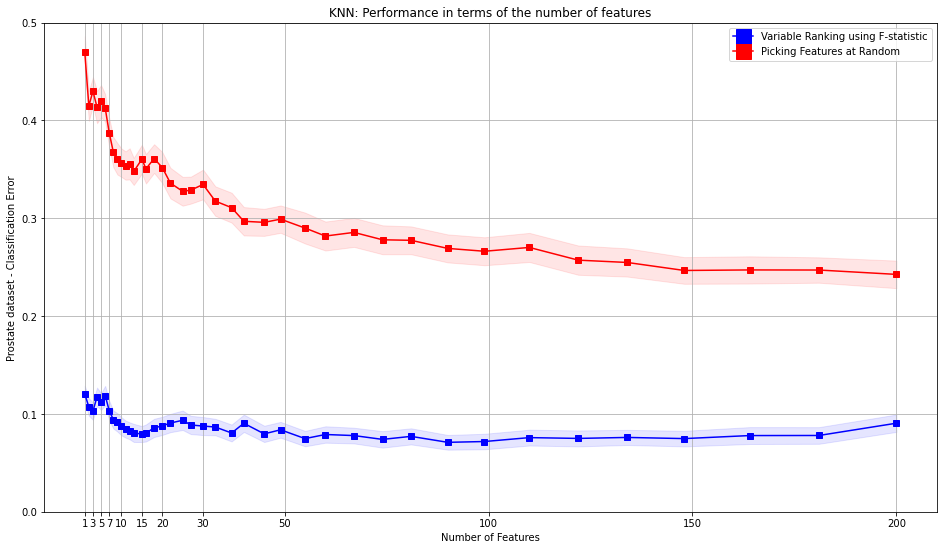

In [36]:
sel = np.arange(1, len(n_features) + 1, 8) - 1

plt.figure(figsize=(16,9))
line1, = plt.plot(n_features, error, 's-', color="b")
line2, = plt.plot(n_features, error_random, 's-', color="r")
plt.fill_between(n_features, error - error_std, error + error_std, alpha=0.1, color="b")
plt.fill_between(n_features, error_random - error_random_std, \
    error_random + error_random_std, alpha=0.1, color="r")
plt.grid()
plt.title("KNN: Performance in terms of the number of features")
plt.xlabel('Number of Features')
#plt.xticks(np.array(n_features[ sel ]))
plt.xticks(np.array([1, 3, 5, 7, 10, 15, 20, 30, 50, 100, 150, 200]))
plt.ylabel('Prostate - Classification Error')
plt.ylim(0.0,  0.5)
legend_handles = [ mlines.Line2D([], [], color='b', marker='s', \
    markersize=15, label='Variable Ranking using F-statistic'),
    mlines.Line2D([], [], color='r', marker='s', \
    markersize=15, label='Picking Features at Random') ]
plt.legend(handles=legend_handles, loc = 1)
plt.show()

## Repeating that process when the feature selection is done externally to the cross validation  

In [39]:

#We set 10 times 10 k fold
n_repeats = 10

rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)


#we set the range of n_features to test
n_features = np.unique(np.round(np.exp(np.arange(0, np.log(210), 0.1))).astype(np.int))

errors_3knn_out = np.zeros((10 * n_repeats, len(n_features)))

split = 0

for i in range(len(n_features)):

    # Filtering outside with f_score variable ranking

    filtering = SelectKBest(f_classif, k = n_features[ len(n_features) - i - 1 ])
    filtering.fit(X, y)

    X_sel = filtering.transform(X)
    
for train_index, test_index in rkf.split(X_sel, y):
    
    
    # We print a dot for each train / test partition-partitiotions from the data selected outside previously 
    
    sys.stdout.write('.')
    sys.stdout.flush()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # We standardize the data

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # fitting the model

    knn.fit(X_train, y_train)
    errors_3knn_out[ split, len(n_features) - i - 1 ] = 1.0 - np.mean(knn.predict(X_test) == y_test)
        
    split += 1

....................................................................................................

In [41]:
error_out = np.mean(errors_3knn_out, 0)
error_out_std = np.std(errors_3knn_out, 0) / np.sqrt(errors_3knn_out.shape[ 0 ])

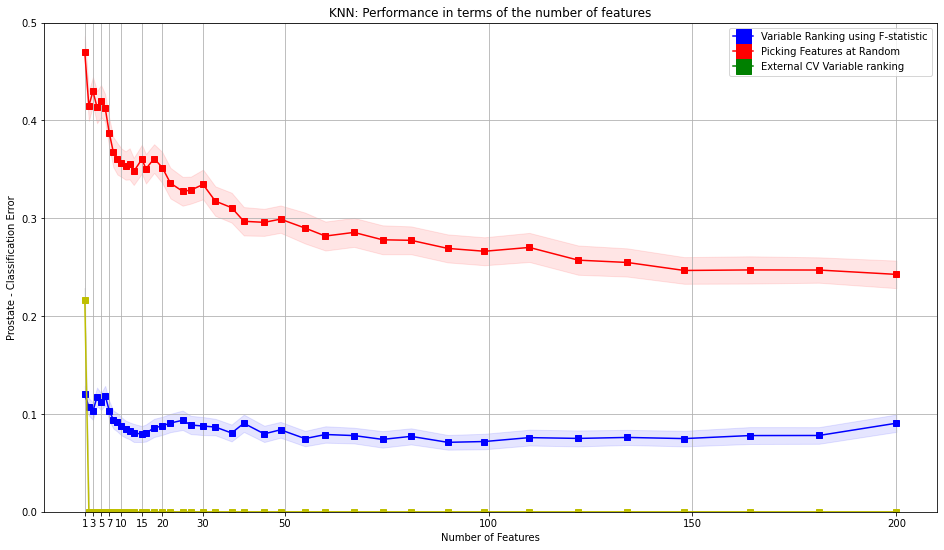

In [43]:
sel = np.arange(1, len(n_features) + 1, 8) - 1

plt.figure(figsize=(16,9))
line1, = plt.plot(n_features, error, 's-', color="b")
line2, = plt.plot(n_features, error_random, 's-', color="r")
line3, = plt.plot(n_features, error_out, 's-', color="y")
plt.fill_between(n_features, error - error_std, error + error_std, alpha=0.1, color="b")
plt.fill_between(n_features, error_out - error_out_std, error_out + error_out_std, alpha=0.1, color="k")
plt.fill_between(n_features, error_random - error_random_std, \
    error_random + error_random_std, alpha=0.1, color="r")
plt.grid()
plt.title("KNN: Performance in terms of the number of features")
plt.xlabel('Number of Features')
#plt.xticks(np.array(n_features[ sel ]))
plt.xticks(np.array([1, 3, 5, 7, 10, 15, 20, 30, 50, 100, 150, 200]))
plt.ylabel('Prostate - Classification Error')
plt.ylim(0.0,  0.5)
legend_handles = [ mlines.Line2D([], [], color='b', marker='s', \
    markersize=15, label='Variable Ranking using F-statistic'),
    mlines.Line2D([], [], color='r', marker='s', \
    markersize=15, label='Picking Features at Random'),
    mlines.Line2D([], [], color = 'g', marker='s', \
    markersize=15, label='External CV Variable ranking')]
plt.legend(handles=legend_handles, loc = 1)
plt.show()